In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
splits = ('train', 'val', 'test')
dfs = dict()

for split in splits:
    dfs[split] = pd.read_csv(f'./datasets/aaai-constraint-covid-appended/{split}.csv', index_col=0)

print(
    *(f'{split}_df.shape = {dfs[split].shape}' for split in splits), 
    'columns:', *(f'    {i}. {c}' for i, c in enumerate(dfs['train'].columns)), 
    sep='\n',
)

train_df.shape = (6420, 21)
val_df.shape = (2140, 21)
test_df.shape = (2140, 21)
columns:
    0. tweet
    1. label
    2. Segment
    3. WPS
    4. allnone
    5. cause
    6. discrep
    7. certitude
    8. tone_pos
    9. tone_neg
    10. swear
    11. Perception
    12. motion
    13. space
    14. auditory
    15. feeling
    16. Conversation
    17. netspeak
    18. assent
    19. QMark
    20. Exclam


In [3]:
for split in splits:
    dfs[split] = dfs[split].drop(['tweet', 'Segment'], axis=1)
    dfs[split].label = dfs[split].label.map({'fake': 0, 'real': 1})
    dfs[split] = dfs[split].rename(columns={x: x.lower() for x in dfs[split].columns})
    columns = dfs[split].columns.tolist()
    dfs[split] = dfs[split][columns[1:]+[columns[0]]]

columns = dfs['train'].columns.tolist()
print(
    *(f'{split}_df.shape = {dfs[split].shape}' for split in splits), 
    'columns:', *(f'    {i}. {c}' for i, c in enumerate(columns)), 
    sep='\n',
)

train_df.shape = (6420, 20)
val_df.shape = (2140, 20)
test_df.shape = (2140, 20)
columns:
    0. segment
    1. wps
    2. allnone
    3. cause
    4. discrep
    5. certitude
    6. tone_pos
    7. tone_neg
    8. swear
    9. perception
    10. motion
    11. space
    12. auditory
    13. feeling
    14. conversation
    15. netspeak
    16. assent
    17. qmark
    18. exclam
    19. label


In [20]:
def grid_search(model, param_grid):

    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3,)

    clf.fit(dfs['train'].iloc[:, :-1], dfs['train'].iloc[:, -1],)
    print('Best parameters:', *(f'    {k}: {v}' for k, v in clf.best_params_.items()), sep='\n',)

    print(f"\nTraining accuracy: {100 * clf.score(dfs['train'].iloc[:, :-1], dfs['train'].iloc[:, -1]):.3f}%")
    print(f"Validation accuracy: {100 * clf.score(dfs['val'].iloc[:, :-1], dfs['val'].iloc[:, -1]):.3f}%")

    return clf

In [30]:
model = SVC()
param_grid = {
    'C': (1, 10, 100,),
    'kernel': ('poly', 'rbf',),
}

clf = grid_search(model=model, param_grid=param_grid)

Best parameters:
    C: 100
    kernel: rbf

Training accuracy: 82.726%
Validation accuracy: 79.766%


In [21]:
model = DecisionTreeClassifier(splitter='best')
param_grid = {
    'criterion': ('gini', 'entropy',),
    'max_depth': (5, 6, 7, 8, 9,),
}

clf = grid_search(model=model, param_grid=param_grid)

Best parameters:
    criterion: entropy
    max_depth: 8

Training accuracy: 83.255%
Validation accuracy: 79.393%


Training accuracy: 70.950%
Validation accuracy: 71.402%

|--- conversation <= 1.60
|   |--- tone_pos <= 1.90
|   |   |--- class: fake
|   |--- tone_pos >  1.90
|   |   |--- class: fake
|--- conversation >  1.60
|   |--- tone_neg <= 4.71
|   |   |--- class: real
|   |--- tone_neg >  4.71
|   |   |--- class: real



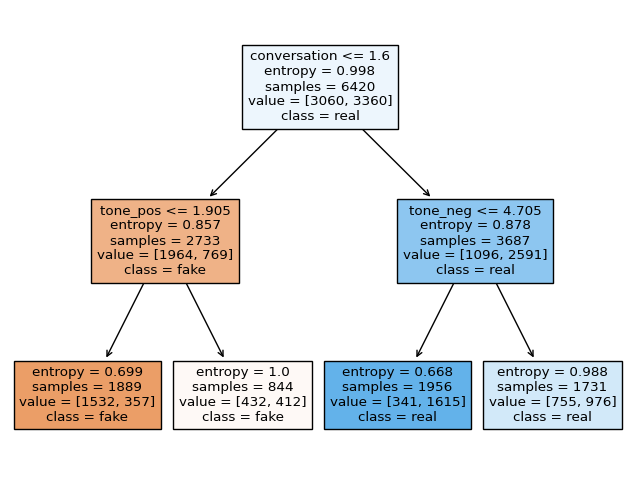

In [23]:
model.set_params(criterion='entropy', max_depth=2)
model.fit(dfs['train'].iloc[:, :-1], dfs['train'].iloc[:, -1],)

print(f"Training accuracy: {100 * accuracy_score(model.predict(dfs['train'].iloc[:, :-1]), dfs['train'].iloc[:, -1]):.3f}%")
print(f"Validation accuracy: {100 * accuracy_score(model.predict(dfs['val'].iloc[:, :-1]), dfs['val'].iloc[:, -1]):.3f}%\n")

print(export_text(model, feature_names=columns[:-1], class_names=['fake', 'real']))

fig = plt.figure(figsize=(8, 6))
_ = plot_tree(model, feature_names=columns[:-1], class_names=['fake', 'real'], filled=True)

In [24]:
model = RandomForestClassifier(criterion='entropy')
param_grid = {
    'n_estimators': (50, 100, 150, 200,),
}

clf = grid_search(model=model, param_grid=param_grid)

Best parameters:
    n_estimators: 100

Training accuracy: 98.333%
Validation accuracy: 81.121%


In [26]:
model = XGBClassifier()
param_grid = {
    'booster': ('gbtree', 'gblinear',),
}

clf = grid_search(model=model, param_grid=param_grid)

Best parameters:
    booster: gbtree

Training accuracy: 92.539%
Validation accuracy: 80.935%


In [13]:
import numpy as np
import torch
from torch.utils.data import default_collate, TensorDataset, DataLoader
from torch.nn import Module, ModuleList, Linear, GELU, Dropout, BCELoss
from torch.optim import AdamW
from torchmetrics import Accuracy, F1Score

In [14]:
def normalize(X_train, X_val, eps=1e-6):

    mean, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
    X_train = (X_train-mean) / (std+eps)
    X_val = (X_val-mean) / (std+eps)

    return X_train, X_val

In [15]:
X_train, y_train = dfs['train'].iloc[:, :-1].values, dfs['train'].iloc[:, -1].values
X_val, y_val = dfs['val'].iloc[:, :-1].values, dfs['val'].iloc[:, -1].values

X_train, X_val = normalize(X_train, X_val)

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))

train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=default_collate, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=default_collate, shuffle=True)

In [18]:
class Model(Module):

    def __init__(self, input_shape=19, hidden_size=128, layers=4, dropout=0.1):

        super(Model, self).__init__()

        dense_layers = list()
        for in_features, out_features in zip([input_shape]+[hidden_size]*(layers-1), [hidden_size]*(layers-1)+[1]):
            dense_layer = Linear(in_features=in_features, out_features=out_features, bias=True)
            dense_layers.append(dense_layer)

        self.dense_layers = ModuleList(dense_layers)
        self.activation = GELU()
        self.dropout = Dropout(p=dropout, inplace=False)

        self.loss = BCELoss()

    def forward(self, x, y):

        for dense_layer in self.dense_layers[:-1]:
            x = dense_layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        
        logits = self.dense_layers[-1](x).squeeze(-1)
        probs = torch.sigmoid(logits)
        preds = torch.round(probs).detach().cpu()
        loss = self.loss(probs, y.float())

        return preds, loss
    
model = Model(input_shape=X_train.shape[-1], hidden_size=128, layers=4, dropout=0.2)
optimizer = AdamW(model.parameters(), lr=5e-4)

In [19]:
accuracy, f1_score = Accuracy(task='binary'), F1Score(task='binary')

for epoch in range(1, 101):

    model.train()
    epoch_labels, epoch_preds, epoch_losses = list(), list(), list()
    for features, labels in train_loader:
        optimizer.zero_grad()
        preds, loss = model(features, labels)
        loss.backward()
        optimizer.step()
        epoch_labels.append(labels.detach().cpu()); epoch_preds.append(preds); epoch_losses.append(loss.item())
    epoch_labels = torch.cat(epoch_labels); epoch_preds = torch.cat(epoch_preds); mean_loss = np.mean(epoch_losses)

    if epoch%10 == 0:
        print(f'Epoch {epoch}\nTraining: Accuracy = {100*accuracy(epoch_preds, epoch_labels).item():.4f}%, F1-Score = {100*f1_score(epoch_preds, epoch_labels).item():.4f}%, Loss = {mean_loss:.6f}')
        model.eval()
        epoch_labels, epoch_preds, epoch_losses = list(), list(), list()
        with torch.no_grad():
            for features, labels in val_loader:
                preds, loss = model(features, labels)
                epoch_labels.append(labels.detach().cpu()); epoch_preds.append(preds); epoch_losses.append(loss.item())
        epoch_labels = torch.cat(epoch_labels); epoch_preds = torch.cat(epoch_preds); mean_loss = np.mean(epoch_losses)
        print(f'Validation: Accuracy = {100*accuracy(epoch_preds, epoch_labels).item():.4f}%, F1-Score = {100*f1_score(epoch_preds, epoch_labels).item():.4f}%, Loss = {mean_loss:.6f}\n')

Epoch 10
Training: Accuracy = 78.4268%, F1-Score = 80.1320%, Loss = 0.459684
Validation: Accuracy = 78.4112%, F1-Score = 79.4667%, Loss = 0.453404

Epoch 20
Training: Accuracy = 80.0312%, F1-Score = 81.5167%, Loss = 0.430629
Validation: Accuracy = 79.8598%, F1-Score = 81.3984%, Loss = 0.442655

Epoch 30
Training: Accuracy = 81.1682%, F1-Score = 82.5617%, Loss = 0.414350
Validation: Accuracy = 80.2336%, F1-Score = 81.5847%, Loss = 0.441176

Epoch 40
Training: Accuracy = 82.1495%, F1-Score = 83.3913%, Loss = 0.399478
Validation: Accuracy = 80.0935%, F1-Score = 81.1170%, Loss = 0.442767

Epoch 50
Training: Accuracy = 82.8816%, F1-Score = 84.0470%, Loss = 0.385640
Validation: Accuracy = 80.3738%, F1-Score = 81.5303%, Loss = 0.450424

Epoch 60
Training: Accuracy = 82.9751%, F1-Score = 84.1157%, Loss = 0.380224
Validation: Accuracy = 80.6075%, F1-Score = 81.6290%, Loss = 0.445891

Epoch 70
Training: Accuracy = 83.7383%, F1-Score = 84.7324%, Loss = 0.363455
Validation: Accuracy = 80.8411%, F1

In [21]:
from tqdm import tqdm

import torch
from transformers import BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader

from data_classes import ConstraintCovid
from data_classes.preprocess import PreProcessor
from utils.tokenizer import tokenize

In [22]:
device = torch.device('cuda:0')
preprocessor = PreProcessor()
datasets = ConstraintCovid(root='datasets/aaai-constraint-covid',)

datasets.apply(
    func=preprocessor.preprocess, 
    splits=['train'], 
    col='tweet', 
    new_col='tweet'
)

In [23]:
model = BertForSequenceClassification.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')
model.load_state_dict(torch.load('results/aaai-constraint-covid/CT-BERT/ckpt4800.pth'))

tokenizer = BertTokenizerFast.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
encoded_inputs, _, _ = tokenize(
    tokenizer,
    datasets,
    splits=['train'],
    max_length=128,
    add_dense=False,
)

input_ids, attention_masks = encoded_inputs['train']['input_ids'], encoded_inputs['train']['attention_mask']
data_loader = DataLoader(TensorDataset(input_ids, attention_masks), batch_size=32, shuffle=False)

100%|██████████| 6420/6420 [00:00<00:00, 6648.47it/s]


In [25]:
model = model.to(device)

with torch.no_grad():
    model.eval()
    probs = list()
    for batch_input_ids, batch_attention_masks in tqdm(data_loader):
        logits = model(input_ids=batch_input_ids.to(device), attention_mask=batch_attention_masks.to(device))[0]
        logits = logits[:, 1]
        probs.append(torch.sigmoid(logits))

probs = torch.cat(probs)

100%|██████████| 201/201 [00:31<00:00,  6.42it/s]
